---
title: "Python Class for NNM using Frank-Wolfe algorithm"
author: "Saikat Banerjee"
format:
  html: default
  ipynb: default
date: "2023-07-19"
file-modified: "2023-07-19"
abstract: "Basically refactoring. We rewrite the functions and put them into a class. Do some basic checks."

---

# About

Here I develop the Python class for weighted nuclear norm minimization using Frank-Wolfe algorithm. 
This is not properly documented, but I keep this notebook for future reference.

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from pymir import mpl_stylesheet
from pymir import mpl_utils

mpl_stylesheet.banskt_presentation(splinecolor = 'black', dpi = 120, colors = 'kelly')

import sys
sys.path.append("../utils/")
import histogram as mpy_histogram
import simulate as mpy_simulate
import plot_functions as mpy_plotfn

In [2]:
#| code-fold: false

ntrait = 4 # categories / class
ngwas  = 500 # N
nsnp   = 1000 # P
nfctr  = 40 # K

In [3]:
Y, Y_true, L, F, mean, noise_var, sample_indices = mpy_simulate.simulate(ngwas, nsnp, ntrait, nfctr, std = 0.5, do_shift_mean = False)
Y_cent = mpy_simulate.do_standardize(Y, scale = False)
Y_std  = mpy_simulate.do_standardize(Y)

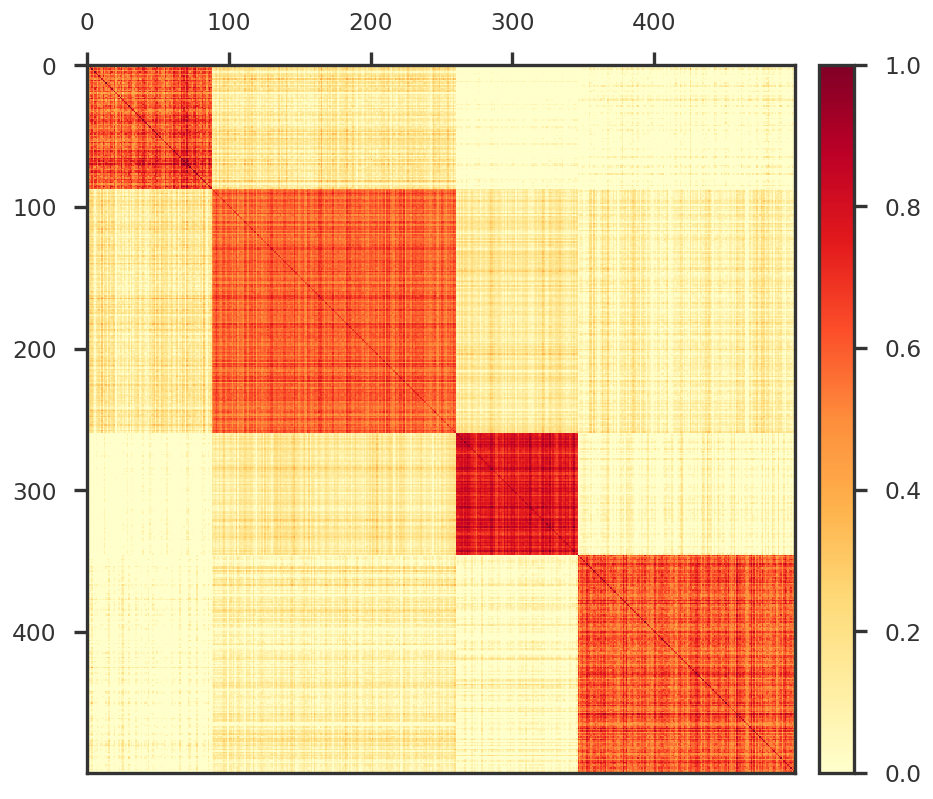

In [4]:
fig = plt.figure(figsize = (8, 8))
ax1 = fig.add_subplot(111)

mpy_plotfn.plot_covariance_heatmap(ax1, L)

plt.tight_layout()
plt.show()

In [5]:
np.linalg.matrix_rank(Y_true)

40

In [6]:
np.linalg.matrix_rank(Y_cent)

499

In [7]:
np.linalg.norm(Y_cent, ord = 'nuc')

6916.216191017533

In [8]:
np.linalg.norm(Y_std, ord = 'nuc')

13488.398215158779

In [9]:
np.linalg.norm(Y_true, ord = 'nuc')

562.4856656633167

# Functions for NNMWF

In [10]:
#| code-fold: false

from sklearn.utils.extmath import randomized_svd

def nuclear_norm(X):
    '''
    Nuclear norm of input matrix
    '''
    return np.sum(np.linalg.svd(X)[1])

def f_objective(X, Y, W = None, mask = None):
    '''
    Objective function
    Y is observed, X is estimated
    W is the weight of each observation.
    '''
    Xmask = X if mask is None else X * mask
    Wmask = W if mask is None else W * mask
    
    # The * operator can be used as a shorthand for np.multiply on ndarrays.
    if Wmask is None:
        f_obj = 0.5 * np.linalg.norm(Y - Xmask, 'fro')**2
    else:
        f_obj = 0.5 * np.linalg.norm(Wmask * (Y - Xmask), 'fro')**2
    return f_obj


def f_gradient(X, Y, W = None, mask = None):
    '''
    Gradient of the objective function.
    '''
    Xmask = X if mask is None else X * mask
    Wmask = W if mask is None else W * mask
    
    if Wmask is None:
        f_grad = Xmask - Y
    else:
        f_grad = np.square(Wmask) * (Xmask - Y)
    
    return f_grad


def linopt_oracle(grad, r = 1.0, max_iter = 10, method = 'power'):
    '''
    Linear optimization oracle,
    where the feasible region is a nuclear norm ball for some r
    '''
    if method == 'power':
        U1, V1_T = singular_vectors_power_method(grad, max_iter = max_iter)
    elif method == 'randomized':
        U1, V1_T = singular_vectors_randomized_method(grad, max_iter = max_iter)
    S = - r * U1 @ V1_T
    return S


def singular_vectors_randomized_method(X, max_iter = 10):
    u, s, vh = randomized_svd(X, n_components = 1, n_iter = max_iter,
                              power_iteration_normalizer = 'none',
                              random_state = 0)
    return u, vh


def singular_vectors_power_method(X, max_iter = 10):
    '''
    Power method.
        
        Computes approximate top left and right singular vector.
        
    Parameters:
    -----------
        X : array {m, n},
            input matrix
        max_iter : integer, optional
            number of steps
            
    Returns:
    --------
        u, v : (n, 1), (p, 1)
            two arrays representing approximate top left and right
            singular vectors.
    '''
    n, p = X.shape
    u = np.random.normal(0, 1, n)
    u /= np.linalg.norm(u)
    v = X.T.dot(u)
    v /= np.linalg.norm(v)
    for _ in range(max_iter):      
        u = X.dot(v)
        u /= np.linalg.norm(u)
        v = X.T.dot(u)
        v /= np.linalg.norm(v)       
    return u.reshape(-1, 1), v.reshape(1, -1)


def do_step_size(dg, D, W = None, old_step = None):
    if W is None:
        denom = np.linalg.norm(D, 'fro')**2
    else:
        denom = np.linalg.norm(W * D, 'fro')**2
    step_size = dg / denom
    step_size = min(step_size, 1.0)
    if step_size < 0:
        print ("Warning: Step Size is less than 0")
        if old_step is not None and old_step > 0:
            print ("Using previous step size")
            step_size = old_step
        else:
            step_size = 1.0
    return step_size


def frank_wolfe_minimize_step(X, Y, r, istep, W = None, mask = None, old_step = None, svd_iter = None, svd_method = 'power'):
    
    # 1. Gradient for X_(t-1)
    G = f_gradient(X, Y, W = W, mask = mask)
    # 2. Linear optimization subproblem
    if svd_iter is None: 
        svd_iter = 10 + int(istep / 20)
        svd_iter = min(svd_iter, 25)
    S = linopt_oracle(G, r, max_iter = svd_iter, method = svd_method)
    # 3. Define D
    D = X - S
    # 4. Duality gap
    dg = np.trace(D.T @ G)
    # 5. Step size
    step = do_step_size(dg, D, W = W, old_step = old_step)
    # 6. Update
    Xnew = X - step * D
    return Xnew, G, dg, step


def frank_wolfe_minimize(Y, r, X0 = None,
                         weight = None,
                         mask = None,
                         max_iter = 1000,
                         svd_iter = None,
                         svd_method = 'power',
                         tol = 1e-4, step_tol = 1e-3, rel_tol = 1e-8,
                         return_all = True,
                         debug = False, debug_step = 10):
    
    # Step 0
    old_X = np.zeros_like(Y) if X0 is None else X0.copy()
    dg = np.inf
    step = 1.0

    if return_all:
        dg_list = [dg]
        fx_list = [f_objective(old_X, Y, W = weight, mask = mask)]
        st_list = [1]
        
    # Steps 1, ..., max_iter
    for istep in range(max_iter):
        X, G, dg, step = \
            frank_wolfe_minimize_step(old_X, Y, r, istep, W = weight, mask = mask, old_step = step, svd_iter = svd_iter, svd_method = svd_method)
        f_obj = f_objective(X, Y, W = weight, mask = mask)
        fx_list.append(f_obj)

        if return_all:
            dg_list.append(dg)
            st_list.append(step)
        
        if debug:
            if (istep % debug_step == 0):
                print (f"Iteration {istep}. Step size {step:.3f}. Duality Gap {dg:g}")
                
        # Stopping criteria
        # duality gap
        if np.abs(dg) <= tol:
            break
        # step size
        if step > 0 and step <= step_tol:
            break
        # relative tolerance of objective function
        f_rel = np.abs((f_obj - fx_list[-2]) / f_obj)
        if f_rel <= rel_tol:
            break
            
        old_X = X.copy()
        
    if return_all:
        return X, dg_list, fx_list, st_list
    else:
        return X

# Class for NNMWF

In [11]:
from sklearn.utils.extmath import randomized_svd

class TopCompSVD():
    
    def __init__(self, method = 'power', max_iter = 10):
        self._method = method
        self._max_iter = max_iter
        return
        
    def fit(self, X):
        if self._method == 'power':
            self._u1, self._v1h = self.fit_power(X)
        elif self._method == 'randomized':
            self._u1, self._v1h = self.fit_randomized(X)
        return
    
    def fit_power(self, X):
        n, p = X.shape
        u = np.random.normal(0, 1, n)
        u /= np.linalg.norm(u)
        v = X.T.dot(u)
        v /= np.linalg.norm(v)
        for _ in range(self._max_iter):      
            u = X.dot(v)
            u /= np.linalg.norm(u)
            v = X.T.dot(u)
            v /= np.linalg.norm(v)       
        return u.reshape(-1, 1), v.reshape(1, -1)
    
    def fit_randomized(self, X):
        u, s, vh = sp.randomized_svd(X, 
                        n_components = 1, n_iter = self._max_iter,
                        power_iteration_normalizer = 'none',
                        random_state = 0)
        return u, vh
    
    @property
    def u1(self):
        return self._u1
    
    @property
    def v1_t(self):
        return self._v1h
        

class NNMFW():
    
    def __init__(self, max_iter = 1000,
            svd_method = 'power', svd_max_iter = None,
            stop_criteria = ['duality_gap', 'step_size', 'relative_objective'],
            tol = 1e-3, step_tol = 1e-3, rel_tol = 1e-8, 
            show_progress = False, print_skip = None,
            debug = True):
        self._max_iter = max_iter
        self._svd_method = svd_method
        self._svd_max_iter = svd_max_iter
        self._stop_criteria = stop_criteria
        self._tol = tol
        self._step_size_tol = step_tol
        self._fxrel_tol = rel_tol
        self._show_progress = show_progress
        self._prog_step_skip = print_skip
        if self._show_progress and self._prog_step_skip is None:
            self._prog_step_skip = max(1, int(self._max_iter / 100)) * 10
        self._debug = debug
        return

    
    def f_objective(self, X):
        '''
        Objective function
        Y is observed, X is estimated
        W is the weight of each observation.
        '''
        Xmask = self.get_masked(X)    
        # The * operator can be used as a shorthand for np.multiply on ndarrays.
        if self._weight_mask is None:
            fx = 0.5 * np.linalg.norm(self._Y - Xmask, 'fro')**2
        else:
            fx = 0.5 * np.linalg.norm(self._weight_mask * (self._Y - Xmask), 'fro')**2
        return fx


    def f_gradient(self, X):
        '''
        Gradient of the objective function.
        '''
        Xmask = self.get_masked(X)       
        if self._weight_mask is None:
            gx = Xmask - self._Y
        else:
            gx = np.square(self._weight_mask) * (Xmask - self._Y)    
        return gx
    
    
    def fw_step_size(self, dg, D):
        if self._weight_mask is None:
            denom = np.linalg.norm(D, 'fro')**2
        else:
            denom = np.linalg.norm(self._weight_mask * D, 'fro')**2
        ss = dg / denom
        ss = min(ss, 1.0)
        if ss < 0:
            print("Step Size is less than 0. Using last valid step size.")
            ss = self._st_list[-1]
        return ss

    
    def get_masked(self, X):
        if self._mask is None or X is None:
            return X
        else:
            return X * self._mask
        
        
    def linopt_oracle(self, X):
        '''
        Linear optimization oracle,
        where the feasible region is a nuclear norm ball for some r
        '''
        U1, V1_T = self.get_singular_vectors(X)
        S = - self._rank * U1 @ V1_T
        return S
    
    
    def get_singular_vectors(self, X):
        max_iter = self._svd_max_iter
        if max_iter is None:
            nstep = len(self._st_list) + 1
            max_iter = 10 + int(nstep / 20)
            max_iter = min(max_iter, 25)
        svd = TopCompSVD(method = self._svd_method, max_iter = max_iter)
        svd.fit(X)
        return svd.u1, svd.v1_t

        
    def fit(self, Y, r, weight = None, mask = None, X0 = None):
        
        '''
        Wrapper function for the minimization
        '''
        
        n, p = Y.shape
        
        # Make some variables available for the class
        self._weight = weight
        self._mask = mask
        self._weight_mask = self.get_masked(self._weight)
        self._Y = Y
        self._rank = r
        
        # Step 0
        X = np.zeros_like(Y) if X0 is None else X0.copy()
        dg = np.inf
        step = 1.0
        fx = self.f_objective(X)
        
        # Save relevant variables in list
        self._dg_list = [dg]
        self._fx_list = [fx]
        self._st_list = [step]

        # Steps 1, ..., max_iter
        for i in range(self._max_iter):
            
            X, G, dg, step = self.fw_one_step(X)
            fx = self.f_objective(X)
            
            self._fx_list.append(fx)
            self._dg_list.append(dg)
            self._st_list.append(step)

            if self._show_progress:
                if (i % self._prog_step_skip == 0):
                    print (f"Iteration {i}. Step size {step:.3f}. Duality Gap {dg:g}")
                    
            if self.do_stop():
                break
                
        self._X = X

        return
    
    def fw_one_step(self, X):
    
        # 1. Gradient for X_(t-1)
        G = self.f_gradient(X)
        
        # 2. Linear optimization subproblem
        S = self.linopt_oracle(G)
        
        # 3. Define D
        D = X - S
        
        # 4. Duality gap
        dg = np.trace(D.T @ G)
        
        # 5. Step size
        step = self.fw_step_size(dg, D)
        
        # 6. Update
        Xnew = X - step * D
        return Xnew, G, dg, step
    
    def do_stop(self):
        # self._stop_criteria = ['duality_gap', 'step_size', 'relative_objective']
        #
        if 'duality_gap' in self._stop_criteria:
            dg = self._dg_list[-1]
            if np.abs(dg) <= self._tol:
                return True
        #
        if 'step_size' in self._stop_criteria:
            ss = self._st_list[-1]
            if ss <= self._step_size_tol:
                return True
        #
        if 'relative_objective' in self._stop_criteria:
            fx = self._fx_list[-1]
            fx0 = self._fx_list[-2]
            fx_rel = np.abs((fx - fx0) / fx0)
            if fx_rel <= self._fxrel_tol:
                return True
        #
        return False

# Try the functions

In [12]:
X_opt, dg_list, fx_list, step_list = frank_wolfe_minimize(Y_cent, 40.0, max_iter = 1000, debug = True, debug_step = 100, step_tol = 1e-4, svd_iter=100)

Iteration 0. Step size 1.000. Duality Gap 2528.37
Using previous step size
Using previous step size


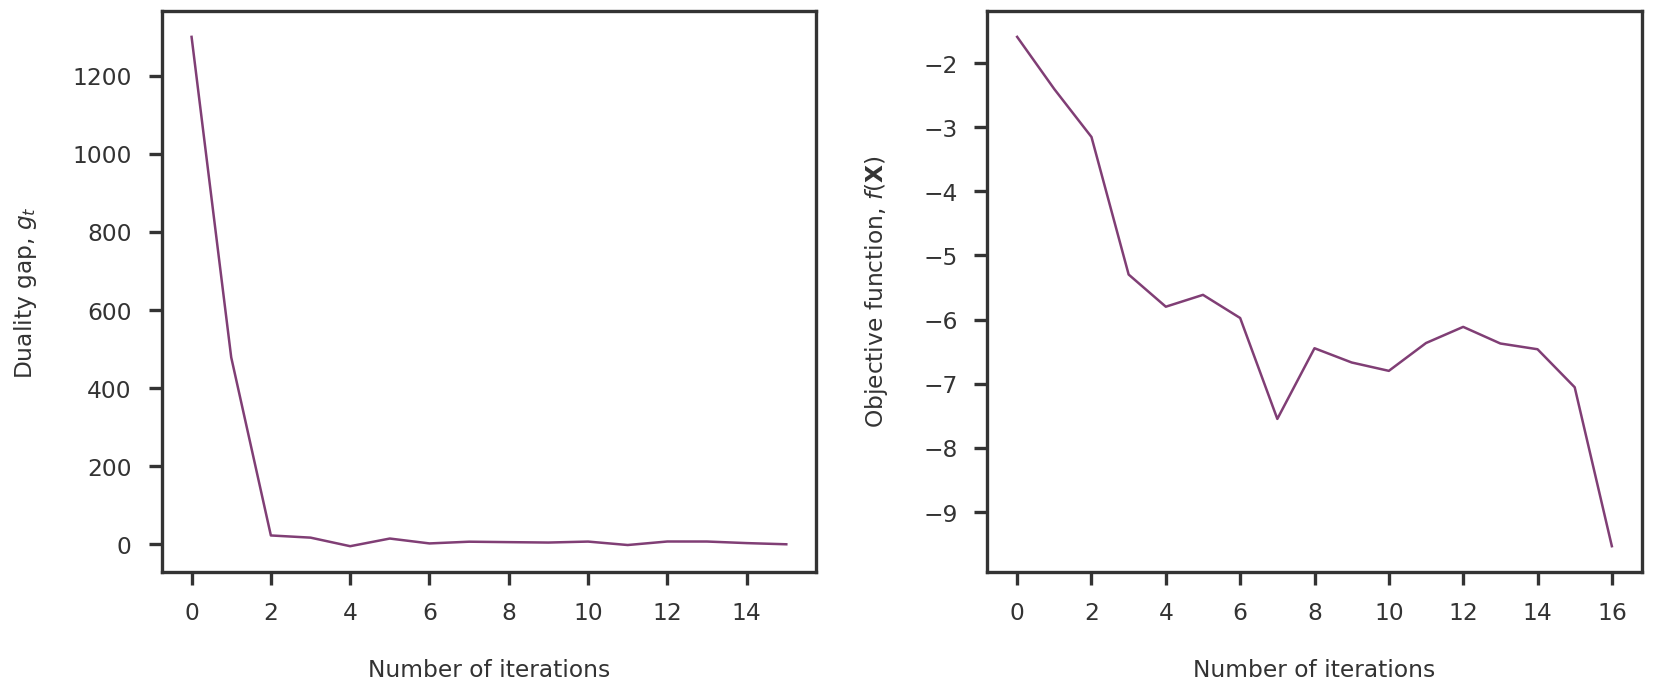

In [13]:
fig = plt.figure(figsize = (14, 6))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

kp = len(step_list)
fx_arr = np.array(fx_list)
fx_rel_diff_log10 = np.log10(np.abs(np.diff(fx_arr) / fx_arr[1:]))

ax1.plot(np.arange(kp - 2), dg_list[2:kp])
# ax2.plot(np.arange(kp - 1), np.log10(fx_list[1:kp]))
ax2.plot(np.arange(kp - 1), fx_rel_diff_log10)

ax1.set_xlabel("Number of iterations")
ax2.set_xlabel("Number of iterations")
ax1.set_ylabel(r"Duality gap, $g_t$")
ax2.set_ylabel(r"Objective function, $f(\mathbf{X})$")
fig.tight_layout(w_pad = 2.0)
plt.show()

# Try the Python Class

In [14]:
nnm = NNMFW(show_progress = True, svd_max_iter = 50)
nnm.fit(Y_cent, 40.0)

Iteration 0. Step size 1.000. Duality Gap 2528.37
Step Size is less than 0. Using last valid step size.


In [15]:
nnm._st_list

[1.0,
 1.0,
 0.4059508526803153,
 0.19713776422660786,
 0.031601077477726426,
 0.011408112527596072,
 0.011435454280280217,
 0.011435454280280217,
 0.0003653454546090821]

In [16]:
nnm._fx_list

[68953.79597625589,
 67225.42267046764,
 66961.74891880063,
 66914.56295271001,
 66914.19909538413,
 66914.12717521715,
 66914.04739067073,
 66914.16163671855,
 66914.16150434242]

In [17]:
fx_list

[68953.79597625589,
 67225.42267046703,
 66961.74891743576,
 66914.56295259335,
 66914.22530475237,
 66914.11898081755,
 66914.28171754857,
 66914.21086735667,
 66914.20897738854,
 66914.1850500866,
 66914.17070820235,
 66914.16008819439,
 66914.13124317658,
 66914.18277041374,
 66914.15440484512,
 66914.13133305841,
 66914.12544153685,
 66914.12542199122]

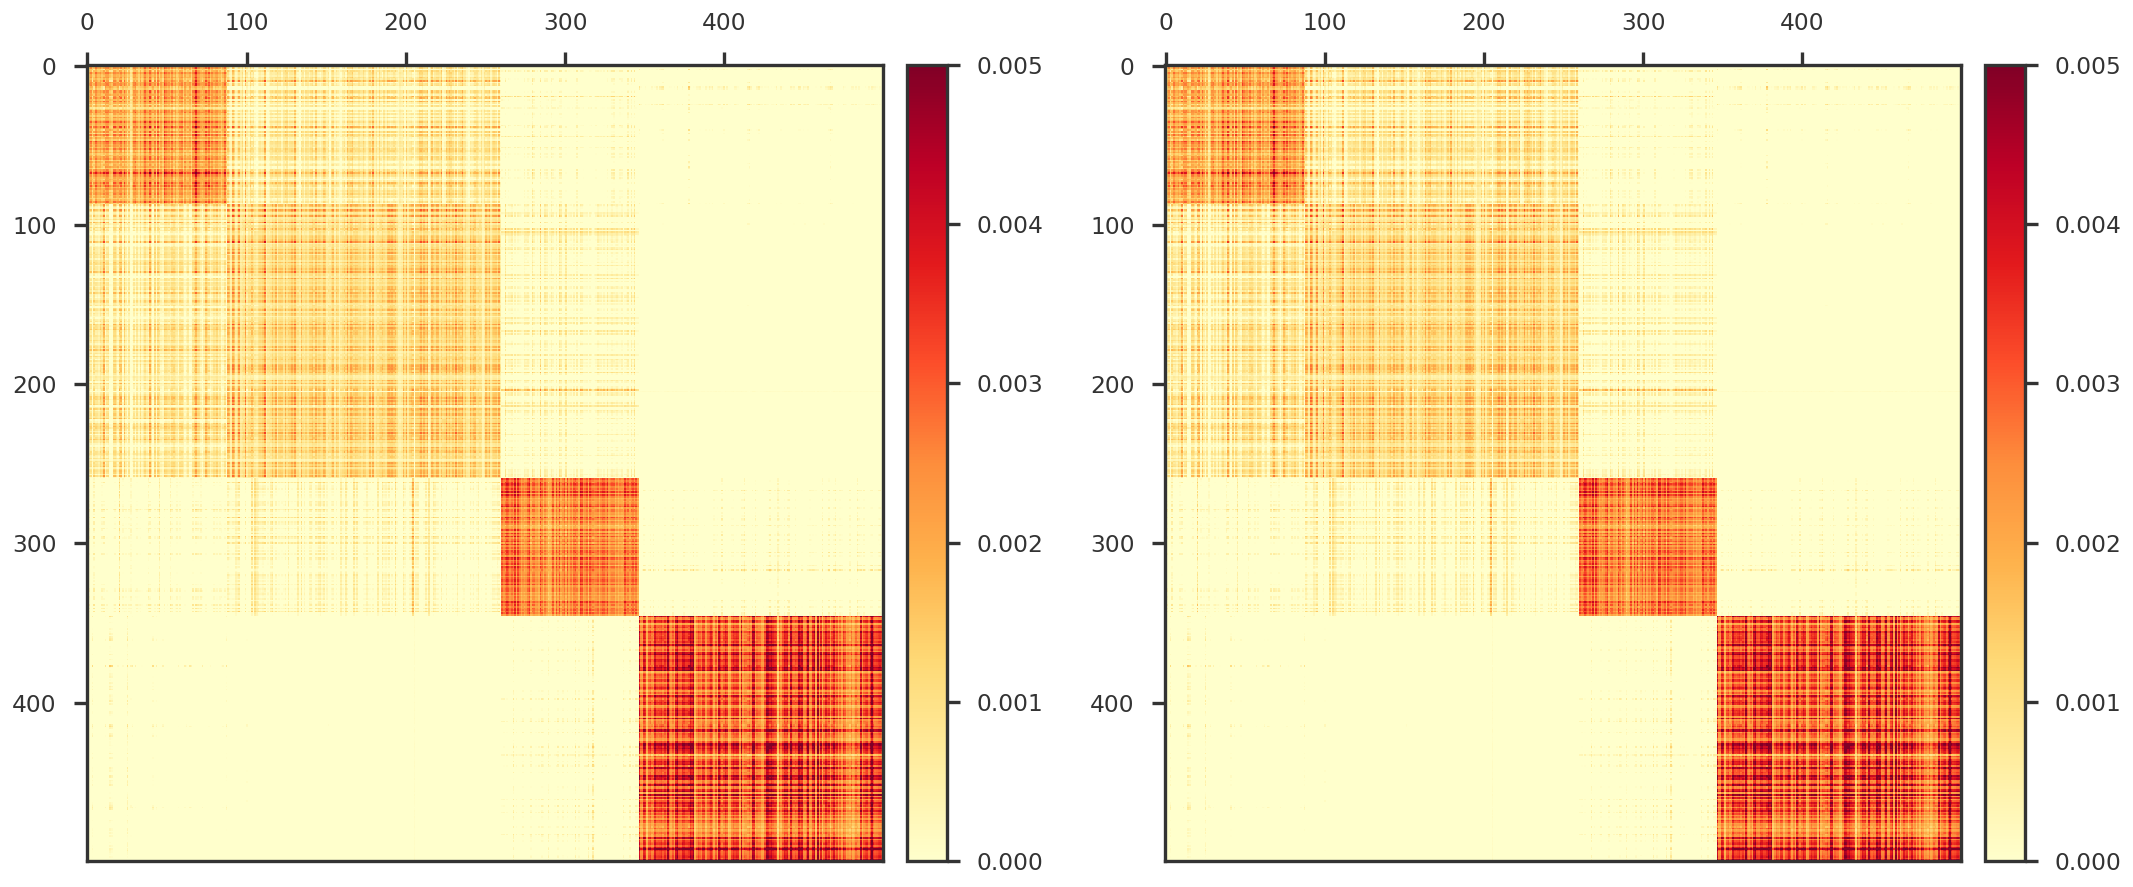

In [18]:
U, S, Vt = np.linalg.svd(mpy_simulate.do_standardize(X_opt, scale = False), full_matrices=False)
U1, S1, Vt1 = np.linalg.svd(mpy_simulate.do_standardize(nnm._X, scale = False), full_matrices=False)

fig = plt.figure(figsize = (18, 8))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

mpy_plotfn.plot_covariance_heatmap(ax1, U @ np.diag(S), vmax = 0.005)
mpy_plotfn.plot_covariance_heatmap(ax2, U1 @ np.diag(S1), vmax = 0.005)

plt.tight_layout(w_pad=2.0)
plt.show()

In [19]:
Y_true_cent = mpy_simulate.do_standardize(Y_true, scale = False)

In [20]:
def psnr(original, recovered):
    n, p = original.shape
    maxsig2 = np.square(np.max(original) - np.min(original))
    mse = np.sum(np.square(recovered - original)) / (n * p)
    res = 10 * np.log10(maxsig2 / mse)
    return res

In [21]:
psnr(Y_true_cent, X_opt)

21.65905757205794

In [22]:
psnr(Y_true_cent, nnm._X)

21.664554727300995

In [23]:
psnr(Y_true_cent, Y_cent)

9.943220233648011

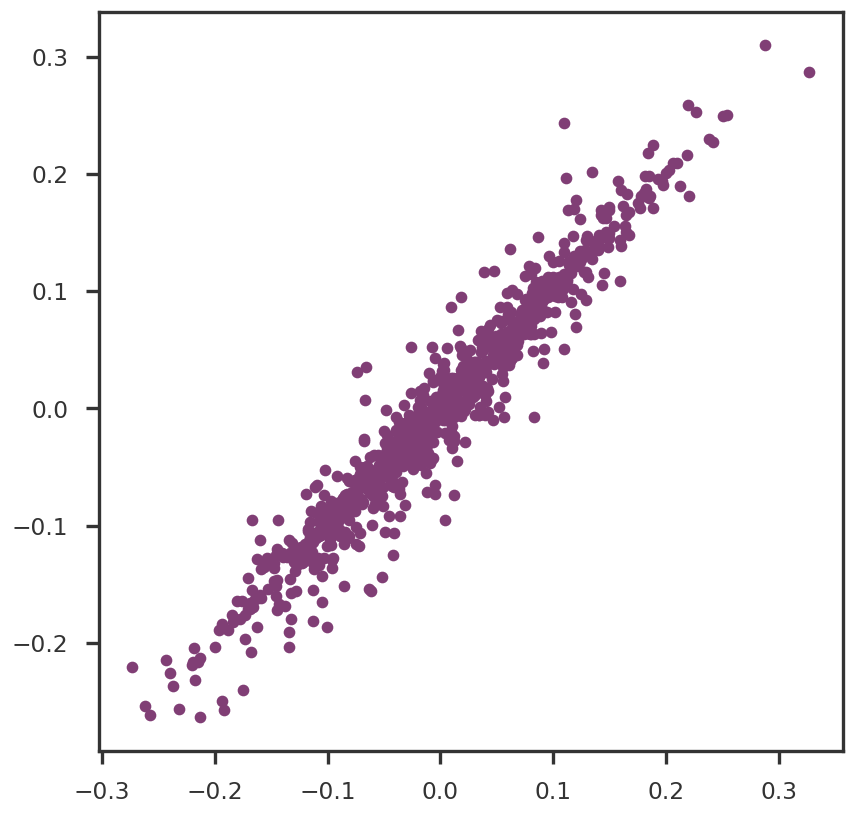

In [24]:
Y_true_mean = np.mean(Y_true, axis = 0)
Y_obs_mean = np.mean(Y, axis = 0)

fig = plt.figure(figsize = (8, 8))
ax1 = fig.add_subplot(111)
ax1.scatter(Y_true_mean, Y_obs_mean)
plt.show()